In [1]:
import funcs
import mrsobs

import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
lvl1path = workDir+'CV3_data/LVL1/'

In [3]:
# select band
band = '3C'

# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [4]:
# # CV3 MIRM33541 (MRS_RAD_11, observations of internal calibration source in nominal and cross-dichroic configurations)
# filename = mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='CV3',output='filename').replace('_LVL2','')
# CV3 MIRM108 (MRS_RAD_14, ramps purposed for non-linearity correction)
filename = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')

image_hdu = fits.open(filename)
image_data = fits.getdata(filename)[:,:1024,:].astype('float')

In [5]:
image_shape = image_data.shape
nints       = image_hdu[0].header['NINT']
ngroups     = image_hdu[0].header['NGROUP']
nframes     = image_shape[0]
readout     = image_hdu[0].header['READOUT']
frame_delta_time = image_hdu[0].header['TFRAME']
print('Number of integrations: {}'.format(nints))
print('Number of groups/frames per integration: {}'.format(ngroups))
print('Total number of frames: {}'.format(nframes))
print('Readout: {}'.format(readout))
print('Time between samples: {} sec'.format(frame_delta_time))
print('LVL1 data shape: {}'.format(image_shape))

Number of integrations: 2
Number of groups/frames per integration: 200
Total number of frames: 400
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (400, 1024, 1032)


In [6]:
image_hdu.close()

<IPython.core.display.Javascript object>


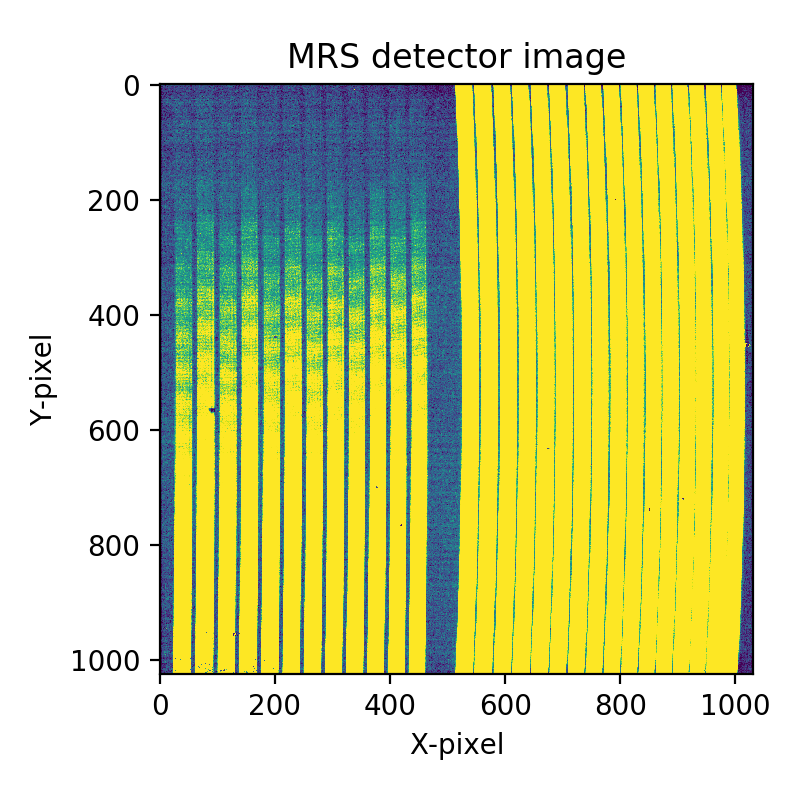

<IPython.core.display.Javascript object>


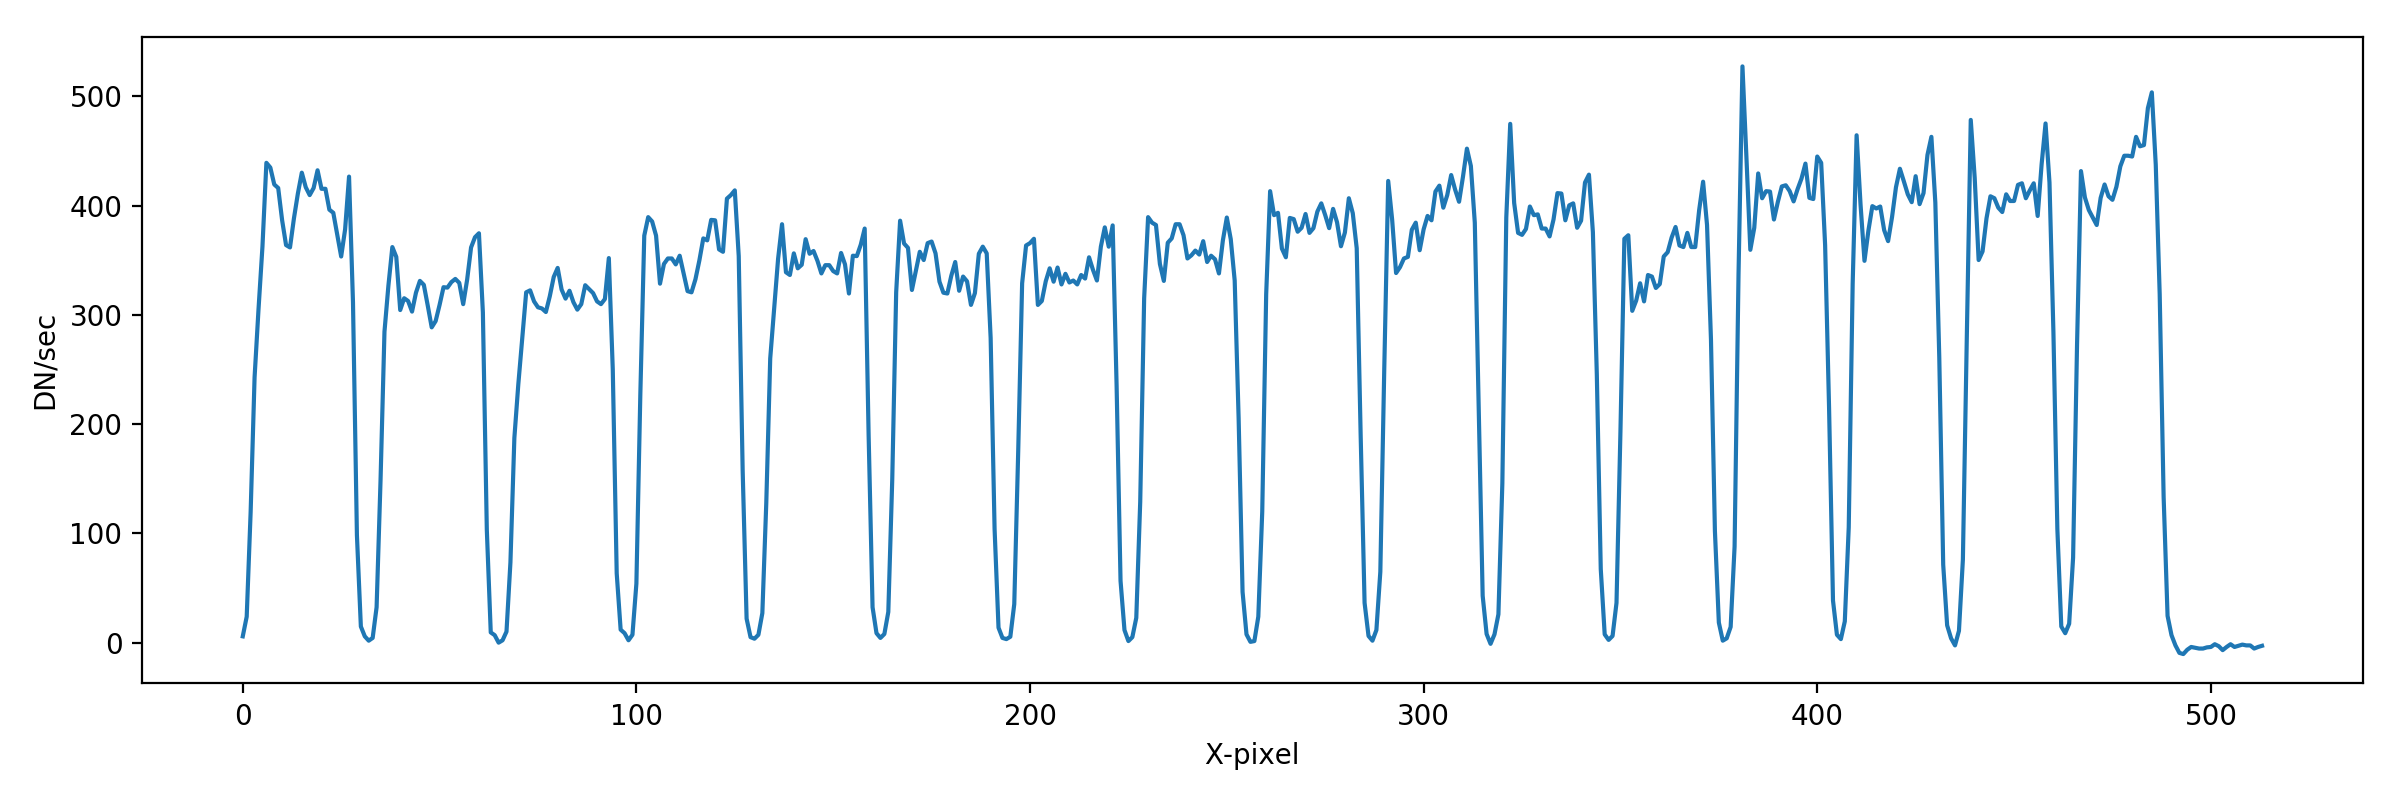

In [7]:
slope_img = (image_data[3,:,:]-image_data[2,:,:])/frame_delta_time
plt.figure(figsize=(4,4))
plt.imshow(slope_img,vmin=-5,vmax=20)
plt.xlabel('X-pixel')
plt.ylabel('Y-pixel')
plt.title('MRS detector image')
plt.tight_layout()

row = 10
plt.figure(figsize=(12,4))
if band[0] in ['1','4']:
    plt.plot(slope_img[row,10:512])
elif band[0] in ['2','3']:
    plt.plot(slope_img[row,512:1026])
plt.xlabel('X-pixel')
plt.ylabel('DN/sec')
plt.tight_layout()

<IPython.core.display.Javascript object>


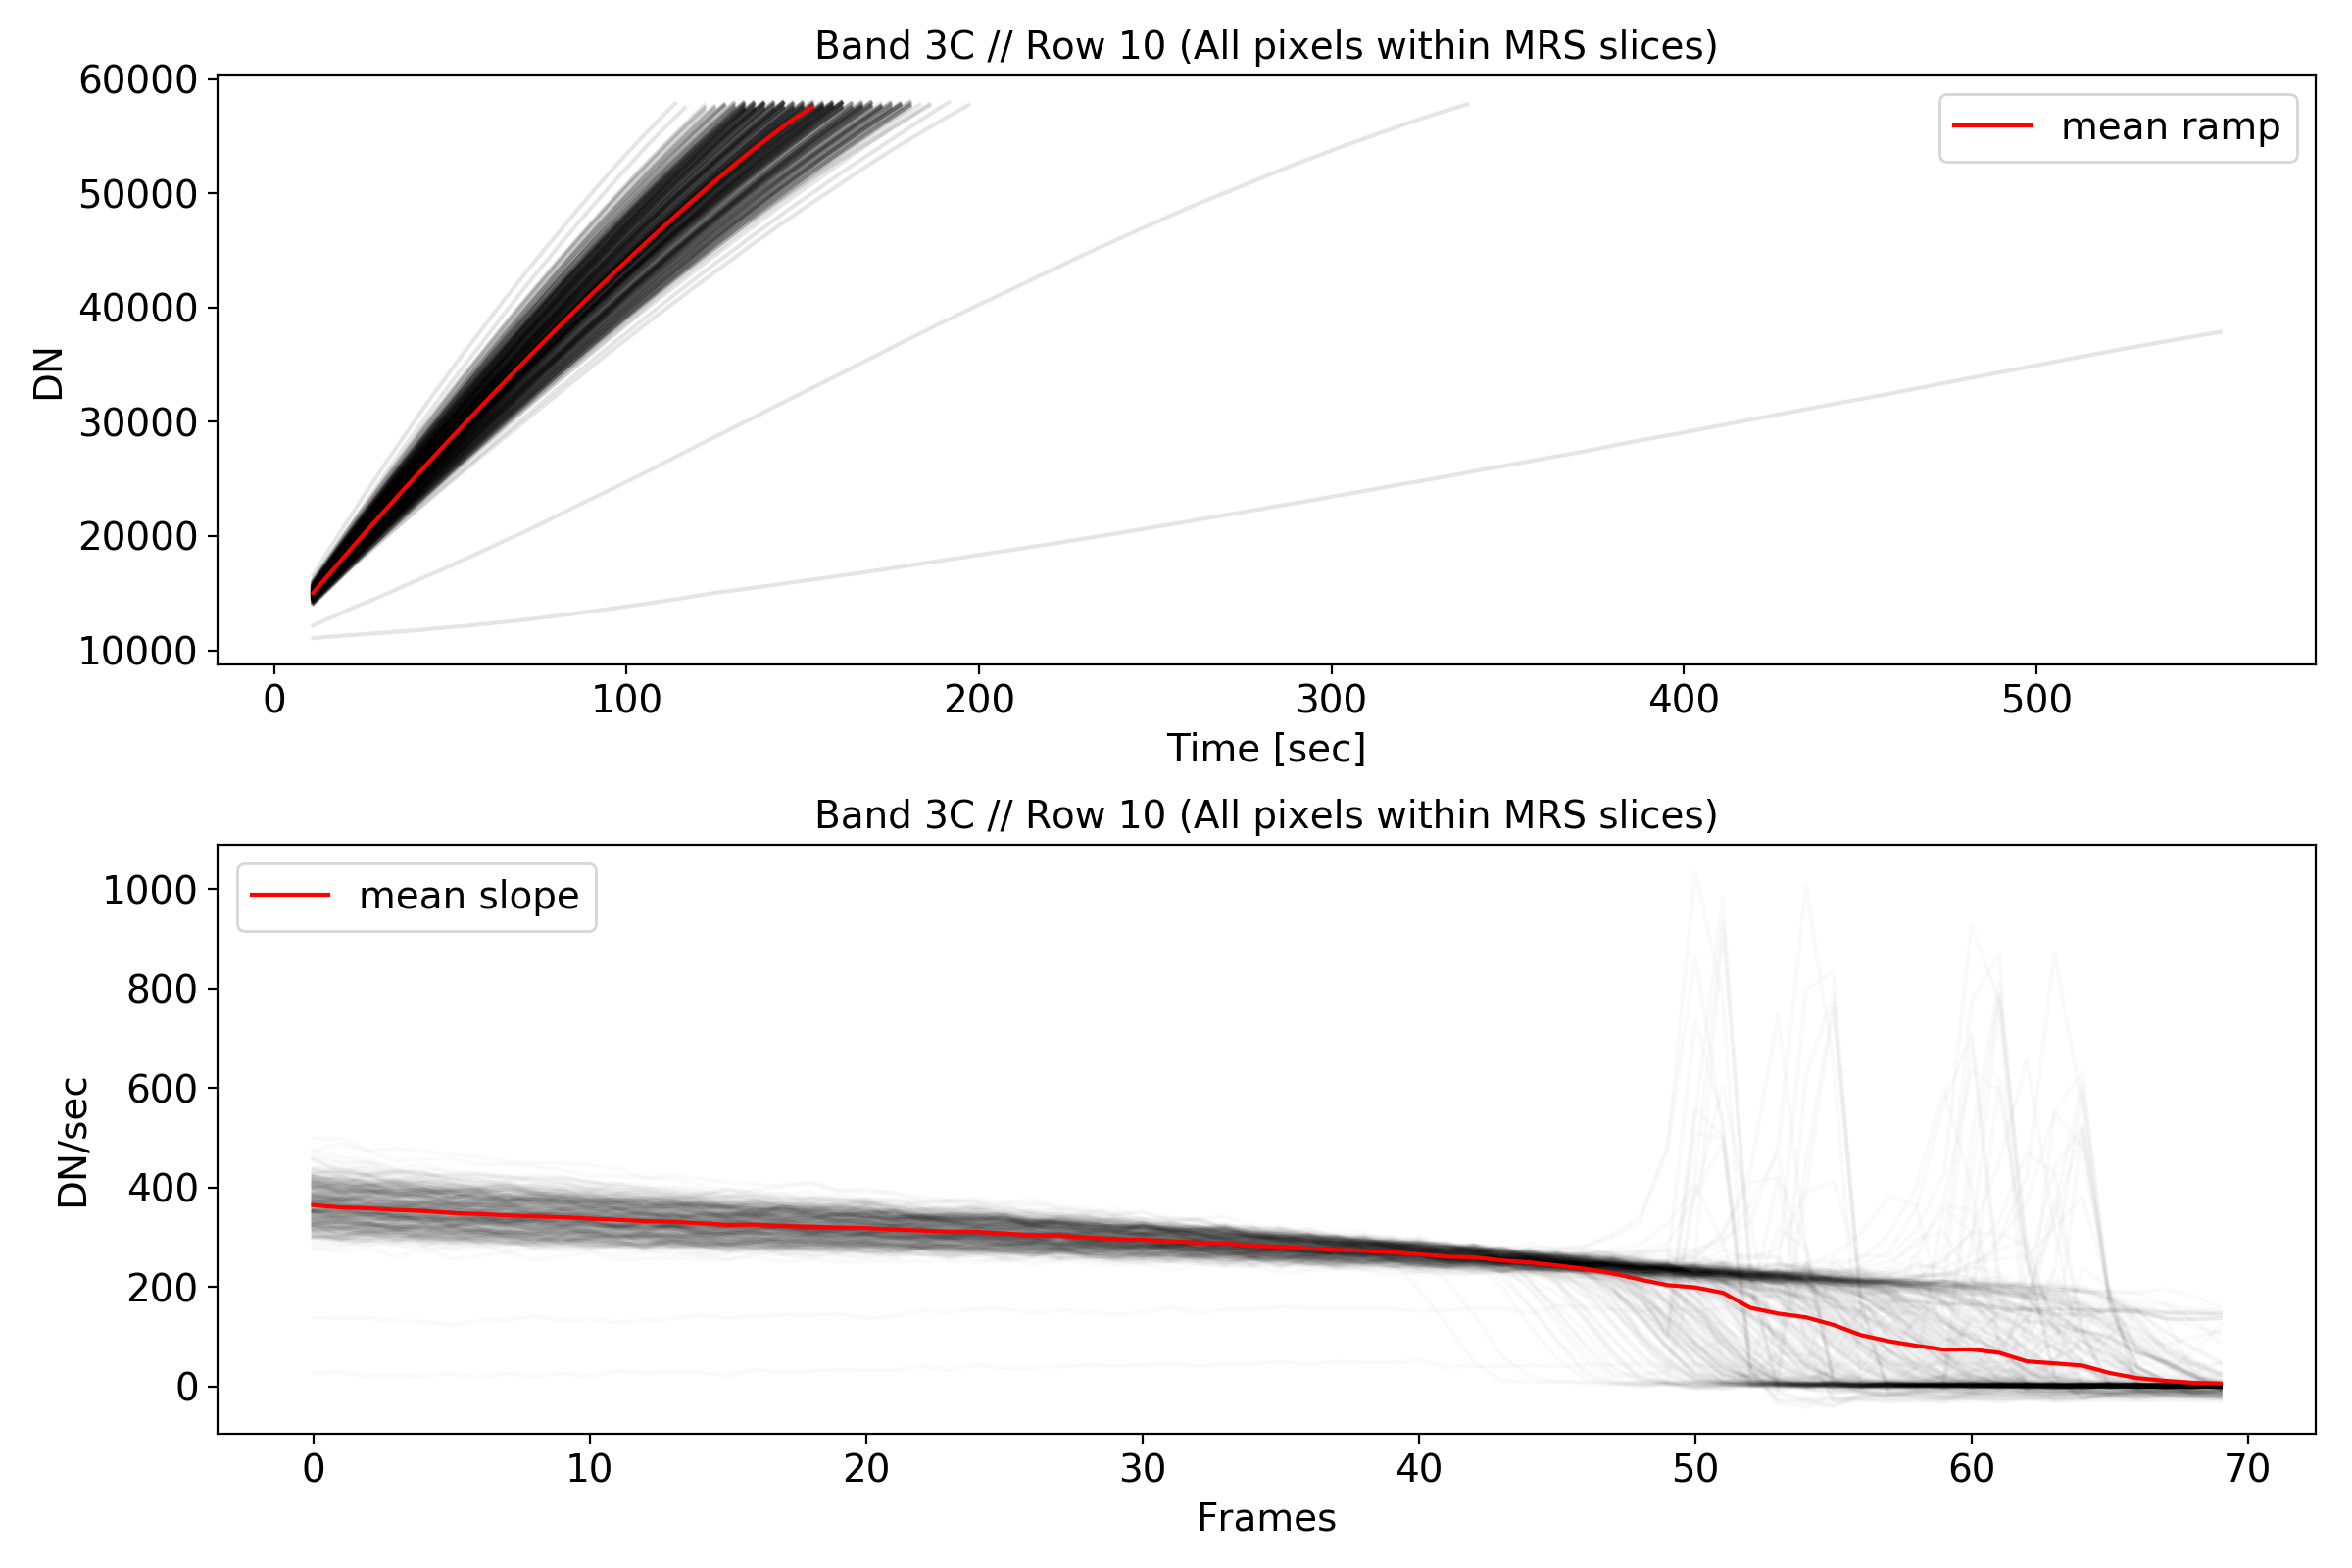

In [11]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
reduced_time = time[skip_first:-skip_last]
ramp_arr,slope_arr = [],[]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

fig,axs = plt.subplots(2,1,figsize=(12,8))
for ypos in [10]:
    for xpos in range_x:
        if d2cMaps['sliceMap'][ypos,xpos] != 0:
            tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
            time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
            time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
            ramp_arr.append(tramp2)
            slope_arr.append(np.diff(tramp2)/frame_delta_time)
            axs[0].plot(time3,tramp3,'k',alpha=0.1)
            axs[1].plot((np.diff(tramp2)/frame_delta_time)[:70],'k',alpha=0.02)
ramp_arr = np.array(ramp_arr)
slope_arr = np.array(slope_arr)
axs[0].plot(time2[np.mean(ramp_arr,axis=0)<58000],np.mean(ramp_arr,axis=0)[np.mean(ramp_arr,axis=0)<58000],'r',label='mean ramp')
axs[1].plot(np.mean(slope_arr,axis=0)[:70],'r',label='mean slope')
axs[0].set_xlabel('Time [sec]',fontsize=14)
axs[0].set_ylabel('DN',fontsize=14)
axs[1].set_xlabel('Frames',fontsize=14)
axs[1].set_ylabel('DN/sec',fontsize=14)
for plot in range(2):
    axs[plot].legend(fontsize=14)
    axs[plot].set_title('Band {} // Row {} (All pixels within MRS slices)'.format(band,ypos),fontsize=14)
    axs[plot].tick_params(axis='both',labelsize=14)
plt.tight_layout()


<IPython.core.display.Javascript object>


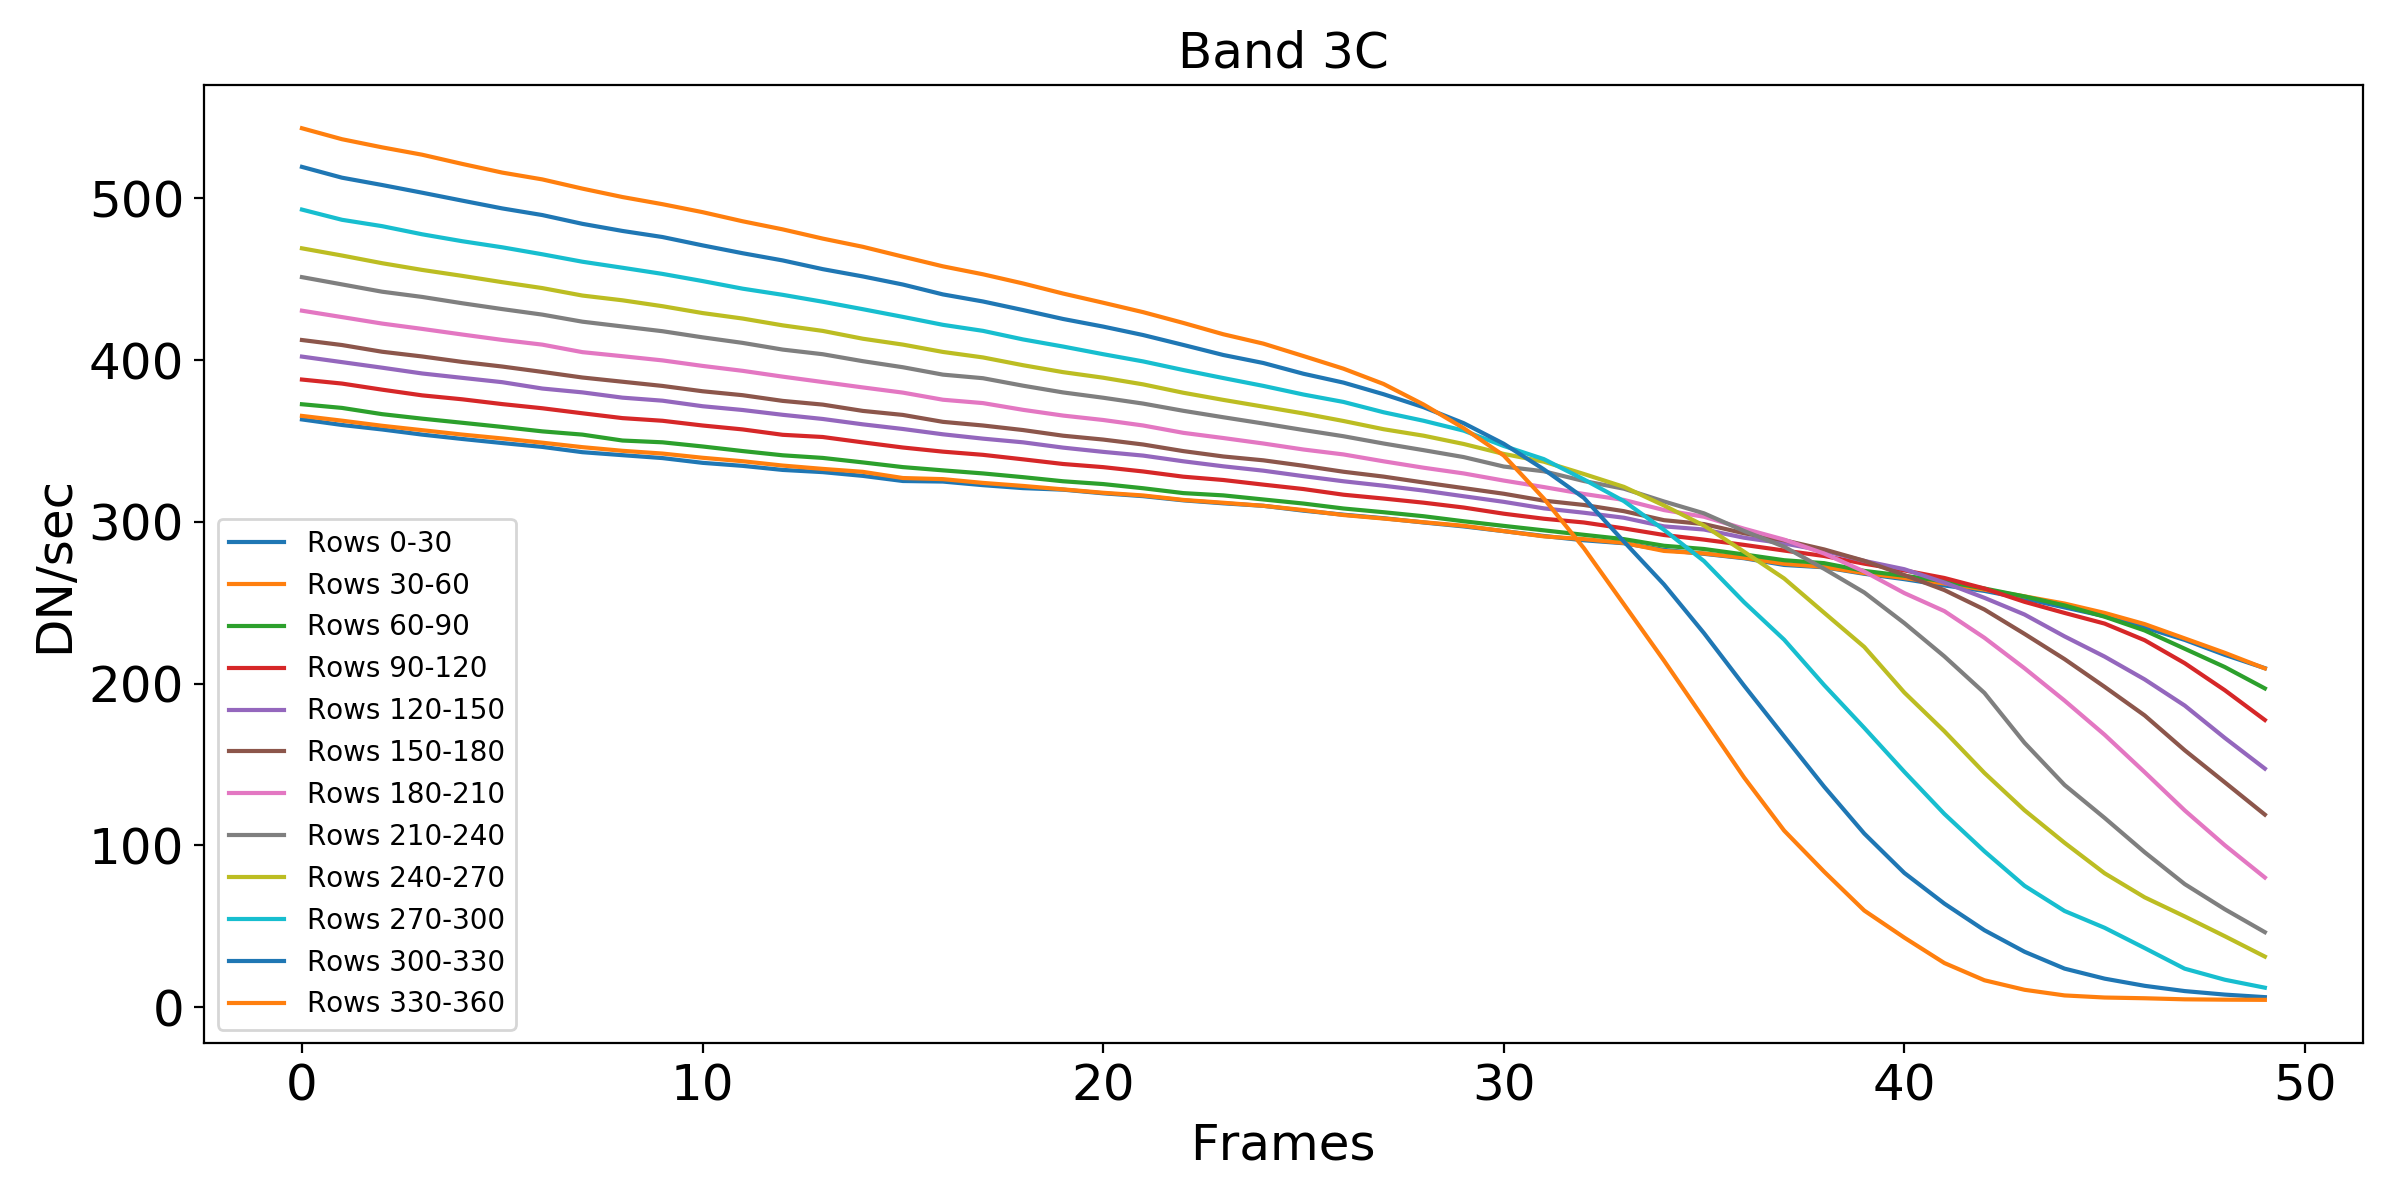

In [14]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

time  = np.arange(1,nframes+1)[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups]*frame_delta_time
reduced_time = time[skip_first:-skip_last]
d2cMaps   = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)

step = 30
plt.figure(figsize=(12,6))
for i in range(12):# range(1024/step - 10):
    ramp_arr = []
    for ypos in range(i*step,(i+1)*step):
        for xpos in range_x:
            if d2cMaps['sliceMap'][ypos,xpos] != 0:
                tramp = image_data[(analyze_ramp-1)*ngroups:analyze_ramp*ngroups,ypos,xpos]
                tramp[np.isnan(tramp)] = 0
                time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
                time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
                ramp_arr.append(tramp2)
    ramp_arr = np.array(ramp_arr)
    plt.plot(np.diff(np.mean(ramp_arr,axis=0))[:50]/frame_delta_time,label='Rows {}-{}'.format(i*step,(i+1)*step))
plt.xlabel('Frames',fontsize=18)
plt.ylabel('DN/sec',fontsize=18)
plt.legend()
plt.title('Band {}'.format(band),fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.tight_layout()